In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import sys,time
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
# Set parameters
# Choose either Re=10000 or Re=100
Re=10000

if Re==10000:
    file_name="./data/snapshot_full_high_Re.p"
    file_name_inter="./data/snapshot_full_inter_high_Re.p"
    nx=60
    ny=60
    nt=1500
elif Re==100:
    file_name="./data/snapshot_full_low_Re.p"
    file_name_inter="./data/snapshot_full_inter_low_Re.p"
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

maxitr=10
tol=1e-8

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [4]:
# first order derivative
# central
Mcb=sp.diags([np.zeros(nx-2),-np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Mc=sp.kron(sp.eye(ny-2),Mcb,format="csr")

Ib=sp.eye(nx-2)
Nc=sp.kron(sp.diags([np.zeros(ny-2),-np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

# forward
Mfb=sp.diags([-np.ones(nx-2),np.ones(nx-2)],[0,1],(nx-2,nx-2))
Mf=sp.kron(sp.eye(ny-2),Mfb,format="csr")

Ib=sp.eye(nx-2)
Nf=sp.kron(sp.diags([-np.ones(ny-2),np.ones(ny-2)],[0,1],(ny-2,ny-2)),Ib,format="csr")

# backward
Mbb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
Mb=sp.kron(sp.eye(ny-2),Mbb,format="csr")

Ib=sp.eye(nx-2)
Nb=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

# Generate snapshots


Amplitude=0.9


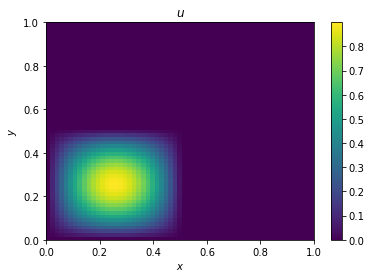

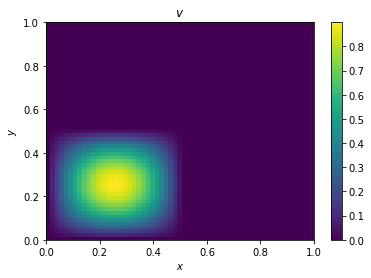

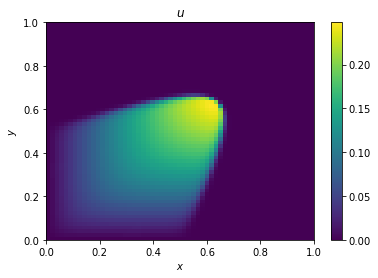

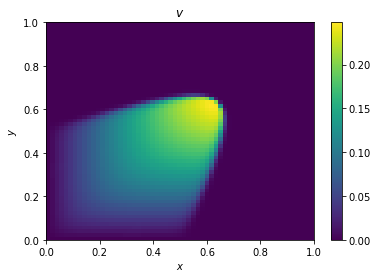


Amplitude=0.95


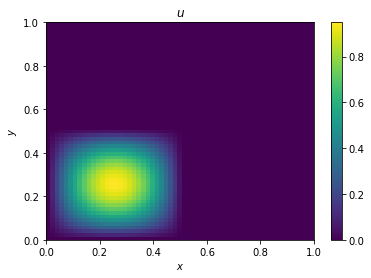

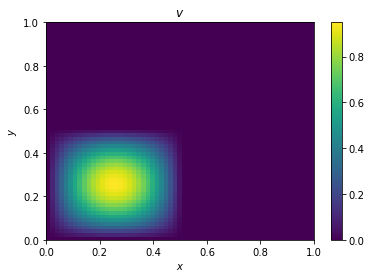

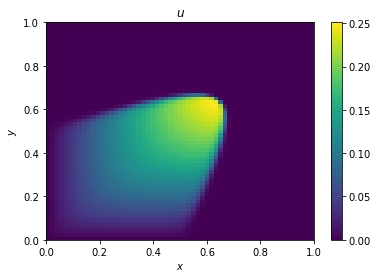

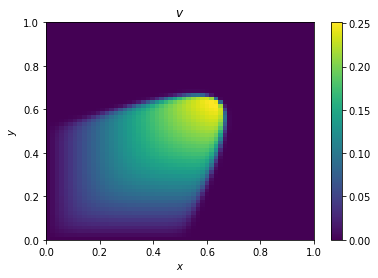


Amplitude=1.05


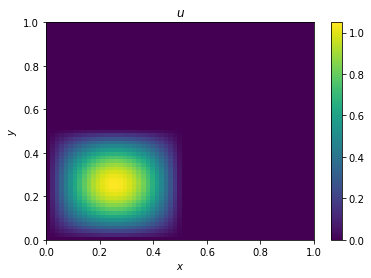

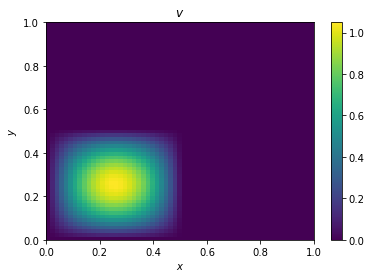

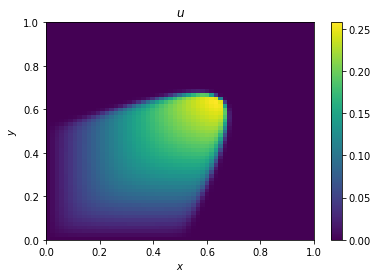

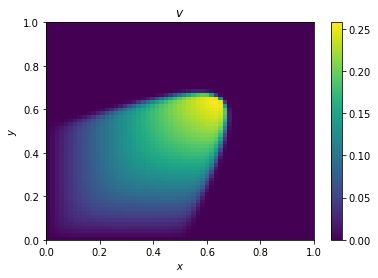


Amplitude=1.1


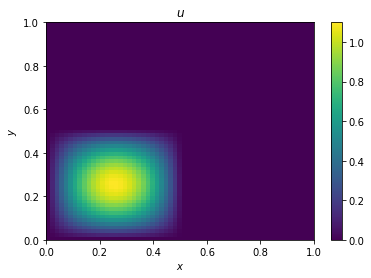

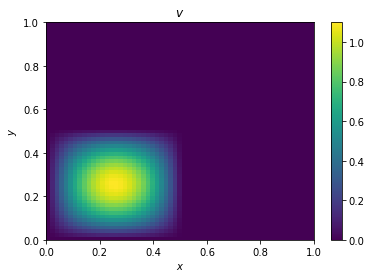

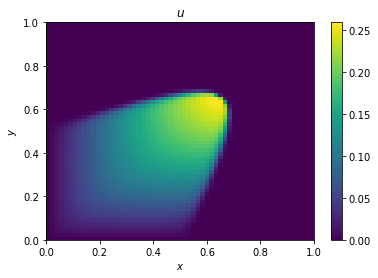

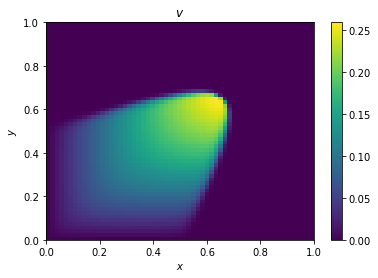


Shape of snapshot u: (6004, 3600)
Shape of snapshot v: (6004, 3600)
Shape of snapshot u and itermediate values: (12000, 3364)
Shape of snapshot v and itermediate values: (12000, 3364)


In [5]:
snapshot_u=np.array([])
snapshot_v=np.array([])

# solution + intermediate snapshot
snapshot_u_inter=np.array([])
snapshot_v_inter=np.array([])

for amp in np.array([0.9,0.95,1.05,1.1]):
    print()
    print('Amplitude={}'.format(amp))
    
    # compute u_full and v_full
    # IC
    zv=amp*np.sin(2*np.pi*xv)*np.sin(2*np.pi*yv)
    zv[np.nonzero(xv>0.5)]=0.0
    zv[np.nonzero(yv>0.5)]=0.0
    z=zv.flatten()

    u0=z.copy()
    v0=z.copy()

    # plot IC
    fig_u = plt.figure()
#     ax_u = Axes3D(fig_u)
#     ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u0.reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
#     ax_u.view_init(elev=30,azim=30)
    ax_u = fig_u.gca()
    p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u0.reshape(ny,nx))
    cb_u=fig_u.colorbar(p_u,ax=ax_u)
    ax_u.set_xlabel('$x$')
    ax_u.set_ylabel('$y$')
    plt.title('$u$')
    plt.show()

    fig_v = plt.figure()
#     ax_v = Axes3D(fig_v)
#     ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v0.reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
#     ax_v.view_init(elev=30,azim=60)
    ax_v = fig_v.gca()
    p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), v0.reshape(ny,nx))
    cb_v=fig_v.colorbar(p_v,ax=ax_v)
    ax_v.set_xlabel('$x$')
    ax_v.set_ylabel('$y$')
    plt.title('$v$')
    plt.show()

    # boundary for first order derivative term
    Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
    Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
    Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
    Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
    Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
    Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
    Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
    Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])

    # boundary for second order derivative term
    bxu_cur=np.zeros(nxy)
    byu_cur=np.zeros(nxy)
    bxv_cur=np.zeros(nxy)
    byv_cur=np.zeros(nxy)

    bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
    byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
    bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
    byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

    def r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
          Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
          bxu_cur,bxv_cur,byu_cur,byv_cur):

        f_u=(-1/dx*(u_free*(Mu_free - Bdudx0_cur))
        -1/dy*(v_free*(Nu_free - Bdudy0_cur))
        +1/(Re*dx**2)*(Dx.dot(u_free) + bxu_cur)
        +1/(Re*dy**2)*(Dy.dot(u_free) + byu_cur))
        f_v=(-1/dx*(u_free*(Mv_free - Bdvdx0_cur))
        -1/dy*(v_free*(Nv_free - Bdvdy0_cur))
        +1/(Re*dx**2)*(Dx.dot(v_free) + bxv_cur)
        +1/(Re*dy**2)*(Dy.dot(v_free) + byv_cur))

        r_u=u_free-u_free_prev-dt*f_u
        r_v=v_free-v_free_prev-dt*f_v

        return np.concatenate((r_u,r_v))



    def J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
          Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur):

        df_udu = (-1/dx*(sp.diags(Mu_free - Bdudx0_cur,0,(nxy,nxy),format="csr") 
                            + sp.diags(u_free,0,(nxy,nxy),format="csr").dot(Mb))
        -1/dy*sp.diags(v_free,0,(nxy,nxy),format="csr").dot(Nb)
        +1/(Re*dx**2)*Dx
        +1/(Re*dy**2)*Dy)
        df_udv = -1/dy*sp.diags(Nu_free - Bdudy0_cur,0,(nxy,nxy),format="csr")
        df_vdu = -1/dx*sp.diags(Mv_free - Bdvdx0_cur,0,(nxy,nxy),format="csr")
        df_vdv = (-1/dx*sp.diags(u_free,0,(nxy,nxy),format="csr").dot(Mb)
        -1/dy*(sp.diags(Nv_free - Bdvdy0_cur,0,(nxy,nxy),format="csr")
                   + sp.diags(v_free,0,(nxy,nxy),format="csr").dot(Nb))
        +1/(Re*dx**2)*Dx
        +1/(Re*dy**2)*Dy)

        return sp.bmat([[I-dt*df_udu,-dt*df_udv],[-dt*df_vdu,I-dt*df_vdv]],format='csr')

    # solution snapshot
    u_full=np.zeros(((nt+1),ny*nx))
    v_full=np.zeros(((nt+1),ny*nx))
    
    # solution + intermediate snapshot
    u_full_inter=np.array([])
    v_full_inter=np.array([])

    # IC
    u_full[0]=np.copy(u0)
    v_full[0]=np.copy(v0)
    u0_free=u0[free_raveled_indicies]
    v0_free=v0[free_raveled_indicies]

    for k in range(nt):
#         print("")
#         print(k,"th time step:")

        u_free_prev=np.copy(u_full[k,free_raveled_indicies])
        v_free_prev=np.copy(v_full[k,free_raveled_indicies])

        u_free=np.copy(u_full[k,free_raveled_indicies])
        v_free=np.copy(v_full[k,free_raveled_indicies])

        Mu_free=Mb.dot(u_free)
        Mv_free=Mb.dot(v_free)
        Nu_free=Nb.dot(u_free)
        Nv_free=Nb.dot(v_free)

        residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                   bxu_cur,bxv_cur,byu_cur,byv_cur)

        for itr in range(maxitr):
            jacobian=J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
                       Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur)

            delta_free=spsolve(jacobian, -residual)

            u_free+=delta_free[:nxy]
            v_free+=delta_free[nxy:]

            Mu_free=Mb.dot(u_free)
            Mv_free=Mb.dot(v_free)
            Nu_free=Nb.dot(u_free)
            Nv_free=Nb.dot(v_free)

            residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                       Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                       bxu_cur,bxv_cur,byu_cur,byv_cur)
       
            # store itermediate values
            u_full_inter = np.append(u_full_inter,u_free)
            v_full_inter = np.append(v_full_inter,v_free)
        
            R=np.linalg.norm(residual)
#             print(itr,"th Newton iteration", "R:", R)

            if R<tol:
                u_full[k+1,free_raveled_indicies]=np.copy(u_free)
                v_full[k+1,free_raveled_indicies]=np.copy(v_free)
                # BC from exact solution
                u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
                v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])
                break

        if R>=tol:
            print("\n non converged after {}th iteration".format(maxitr))
            break     

    #     u_full[k+1,free_raveled_indicies]=np.copy(u_free)
    #     v_full[k+1,free_raveled_indicies]=np.copy(v_free)
    #     # BC from exact solution
    #     u_full[k+1,fixed_raveled_indicies]=np.copy(u[k+1,fixed_raveled_indicies])
    #     v_full[k+1,fixed_raveled_indicies]=np.copy(v[k+1,fixed_raveled_indicies])
    
    u_full_inter=u_full_inter.reshape(-1,nxy)
    v_full_inter=v_full_inter.reshape(-1,nxy)

    # plot solution at finatl time step
    fig_u = plt.figure()
    # ax_u = Axes3D(fig_u)
    # ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
    # ax_u.view_init(elev=30,azim=30)
    ax_u = fig_u.gca()
    p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[-1]).reshape(ny,nx))
    cb_u=fig_u.colorbar(p_u,ax=ax_u)
    ax_u.set_xlabel('$x$')
    ax_u.set_ylabel('$y$')
    plt.title('$u$')
    plt.show()

    fig_v = plt.figure()
    # ax_v = Axes3D(fig_v)
    # ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
    # ax_v.view_init(elev=30,azim=60)
    ax_v = fig_v.gca()
    p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[-1]).reshape(ny,nx))
    cb_v=fig_v.colorbar(p_v,ax=ax_v)
    ax_v.set_xlabel('$x$')
    ax_v.set_ylabel('$y$')
    plt.title('$v$')
    plt.show()    
    
    # append u_full and v_full
    snapshot_u=np.append(snapshot_u,u_full)
    snapshot_v=np.append(snapshot_v,v_full)

    # append u_full_inter and v_full_inter
    snapshot_u_inter=np.append(snapshot_u_inter,u_full_inter)
    snapshot_v_inter=np.append(snapshot_v_inter,v_full_inter)
    
# reshape snapshot_u and snapshot_v
snapshot_u=np.reshape(snapshot_u,(-1,ny*nx))
snapshot_v=np.reshape(snapshot_v,(-1,ny*nx))

# reshape snapshot_u_inter and snapshot_v_inter
snapshot_u_inter=np.reshape(snapshot_u_inter,(-1,nxy))
snapshot_v_inter=np.reshape(snapshot_v_inter,(-1,nxy))

print()
print('Shape of snapshot u:',snapshot_u.shape)
print('Shape of snapshot v:',snapshot_v.shape)
print('Shape of snapshot u and itermediate values:',snapshot_u_inter.shape)
print('Shape of snapshot v and itermediate values:',snapshot_v_inter.shape)

# save snapshots of full solution
snapshot={'u':snapshot_u,'v':snapshot_v}
pickle.dump(snapshot,open(file_name,'wb'))

# save snapshots of full solution and itermediate values
snapshot_inter={'u':snapshot_u_inter,'v':snapshot_v_inter}
pickle.dump(snapshot_inter,open(file_name_inter,'wb'))

# Generate FOM solution

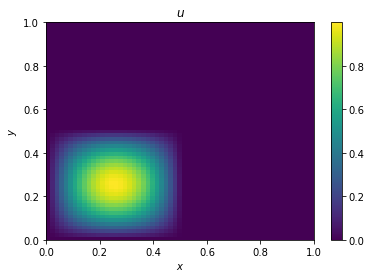

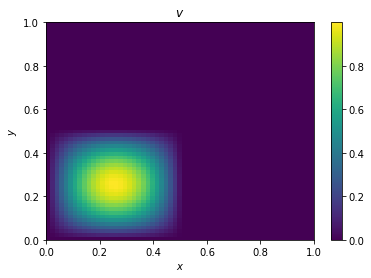

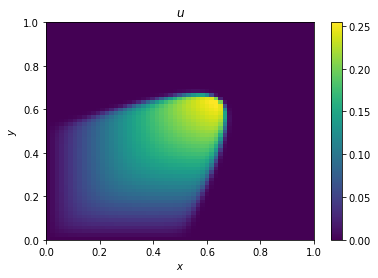

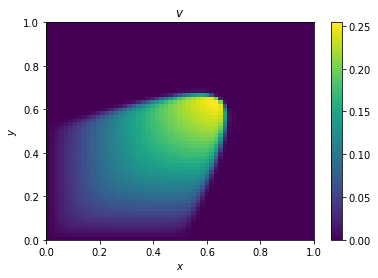


Shape of u full: (1501, 3600)
Shape of v full: (1501, 3600)


In [6]:
# IC
zv=np.sin(2*np.pi*xv)*np.sin(2*np.pi*yv)
zv[np.nonzero(xv>0.5)]=0.0
zv[np.nonzero(yv>0.5)]=0.0
z=zv.flatten()

u0=z.copy()
v0=z.copy()

# plot IC
fig_u = plt.figure()
#     ax_u = Axes3D(fig_u)
#     ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u0.reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
#     ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u0.reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
#     ax_v = Axes3D(fig_v)
#     ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v0.reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
#     ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), v0.reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()

# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])

# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

def r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
      Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
      bxu_cur,bxv_cur,byu_cur,byv_cur):

    f_u=(-1/dx*(u_free*(Mu_free - Bdudx0_cur))
    -1/dy*(v_free*(Nu_free - Bdudy0_cur))
    +1/(Re*dx**2)*(Dx.dot(u_free) + bxu_cur)
    +1/(Re*dy**2)*(Dy.dot(u_free) + byu_cur))
    f_v=(-1/dx*(u_free*(Mv_free - Bdvdx0_cur))
    -1/dy*(v_free*(Nv_free - Bdvdy0_cur))
    +1/(Re*dx**2)*(Dx.dot(v_free) + bxv_cur)
    +1/(Re*dy**2)*(Dy.dot(v_free) + byv_cur))

    r_u=u_free-u_free_prev-dt*f_u
    r_v=v_free-v_free_prev-dt*f_v

    return np.concatenate((r_u,r_v))



def J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
      Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur):

    df_udu = (-1/dx*(sp.diags(Mu_free - Bdudx0_cur,0,(nxy,nxy),format="csr") 
                        + sp.diags(u_free,0,(nxy,nxy),format="csr").dot(Mb))
    -1/dy*sp.diags(v_free,0,(nxy,nxy),format="csr").dot(Nb)
    +1/(Re*dx**2)*Dx
    +1/(Re*dy**2)*Dy)
    df_udv = -1/dy*sp.diags(Nu_free - Bdudy0_cur,0,(nxy,nxy),format="csr")
    df_vdu = -1/dx*sp.diags(Mv_free - Bdvdx0_cur,0,(nxy,nxy),format="csr")
    df_vdv = (-1/dx*sp.diags(u_free,0,(nxy,nxy),format="csr").dot(Mb)
    -1/dy*(sp.diags(Nv_free - Bdvdy0_cur,0,(nxy,nxy),format="csr")
               + sp.diags(v_free,0,(nxy,nxy),format="csr").dot(Nb))
    +1/(Re*dx**2)*Dx
    +1/(Re*dy**2)*Dy)

    return sp.bmat([[I-dt*df_udu,-dt*df_udv],[-dt*df_vdu,I-dt*df_vdv]],format='csr')

# solution snapshot
u_full=np.zeros(((nt+1),ny*nx))
v_full=np.zeros(((nt+1),ny*nx))

# IC
u_full[0]=np.copy(u0)
v_full[0]=np.copy(v0)
u0_free=u0[free_raveled_indicies]
v0_free=v0[free_raveled_indicies]

for k in range(nt):
#         print("")
#         print(k,"th time step:")

    u_free_prev=np.copy(u_full[k,free_raveled_indicies])
    v_free_prev=np.copy(v_full[k,free_raveled_indicies])

    u_free=np.copy(u_full[k,free_raveled_indicies])
    v_free=np.copy(v_full[k,free_raveled_indicies])

    Mu_free=Mb.dot(u_free)
    Mv_free=Mb.dot(v_free)
    Nu_free=Nb.dot(u_free)
    Nv_free=Nb.dot(v_free)

    residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
               Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
               bxu_cur,bxv_cur,byu_cur,byv_cur)

    for itr in range(maxitr):
        jacobian=J(u_free,v_free,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur)

        delta_free=spsolve(jacobian, -residual)

        u_free+=delta_free[:nxy]
        v_free+=delta_free[nxy:]

        Mu_free=Mb.dot(u_free)
        Mv_free=Mb.dot(v_free)
        Nu_free=Nb.dot(u_free)
        Nv_free=Nb.dot(v_free)

        residual=r(u_free,v_free,u_free_prev,v_free_prev,Mu_free,Mv_free,Nu_free,Nv_free,
                   Bdudx0_cur,Bdvdx0_cur,Bdudx1_cur,Bdvdx1_cur,Bdudy0_cur,Bdvdy0_cur,Bdudy1_cur,Bdvdy1_cur,
                   bxu_cur,bxv_cur,byu_cur,byv_cur)

        R=np.linalg.norm(residual)
#             print(itr,"th Newton iteration", "R:", R)

        if R<tol:
            u_full[k+1,free_raveled_indicies]=np.copy(u_free)
            v_full[k+1,free_raveled_indicies]=np.copy(v_free)
            # BC from exact solution
            u_full[k+1,fixed_raveled_indicies]=np.copy(u0[fixed_raveled_indicies])
            v_full[k+1,fixed_raveled_indicies]=np.copy(v0[fixed_raveled_indicies])
            break

    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break     

#     u_full[k+1,free_raveled_indicies]=np.copy(u_free)
#     v_full[k+1,free_raveled_indicies]=np.copy(v_free)
#     # BC from exact solution
#     u_full[k+1,fixed_raveled_indicies]=np.copy(u[k+1,fixed_raveled_indicies])
#     v_full[k+1,fixed_raveled_indicies]=np.copy(v[k+1,fixed_raveled_indicies])

# plot solution at finatl time step
fig_u = plt.figure()
# ax_u = Axes3D(fig_u)
# ax_u.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), u_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (u_full[-1]).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$')
plt.show()

fig_v = plt.figure()
# ax_v = Axes3D(fig_v)
# ax_v.plot_surface(x.reshape(ny,nx), y.reshape(ny,nx), v_full[-1].reshape(ny,nx),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
ax_v = fig_v.gca()
p_v=ax_v.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (v_full[-1]).reshape(ny,nx))
cb_v=fig_v.colorbar(p_v,ax=ax_v)
ax_v.set_xlabel('$x$')
ax_v.set_ylabel('$y$')
plt.title('$v$')
plt.show()    

# reshape snapshot_u and snapshot_v
print()
print('Shape of u full:',u_full.shape)
print('Shape of v full:',v_full.shape)

# save snapshots
if Re==10000:
    FOM_high_Re={'u':u_full,'v':v_full}
    pickle.dump(FOM_high_Re,open('./data/FOM_high_Re.p','wb'))
elif Re==100:
    FOM_low_Re={'u':u_full,'v':v_full}
    pickle.dump(FOM_low_Re,open('./data/FOM_low_Re.p','wb'))
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))